In [1]:
import os
import sys

import pickle

import pandas as pd
import numpy as np
import datetime
from dateutil.relativedelta import relativedelta
import sklearn.preprocessing as skp

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms
import arch.unitroot as au
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
py.init_notebook_mode(connected=True)

/opt/anaconda3/envs/crypto-env/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Our files
import dataanalysis as da

## Load data

In [3]:
with open('../Data/coffee.pkl', 'rb') as f:
    coffee_raw = pickle.load(f)

## Initial summary of data

In [4]:
df = coffee_raw
print('Shape: {}\n'.format(df.shape))
print('Indices: \n{}\n{}\n'.format(df.index[:5], df.index[-5:]))
print('Columns: \n{}\n'.format(df.columns))
print('Describe(): \n{}\n'.format(df.describe()))

Shape: (1833, 1)

Indices: 
DatetimeIndex(['2011-01-04', '2011-01-05', '2011-01-06', '2011-01-07',
               '2011-01-10'],
              dtype='datetime64[ns]', name='Date', freq=None)
DatetimeIndex(['2018-05-23', '2018-05-24', '2018-05-25', '2018-05-30',
               '2018-05-31'],
              dtype='datetime64[ns]', name='Date', freq=None)

Columns: 
Index(['Close'], dtype='object')

Describe(): 
             Close
count  1833.000000
mean      1.579341
std       0.439494
min       0.997100
25%       1.250700
50%       1.408300
75%       1.774600
max       2.967500



## Plot data

In [5]:
df = coffee_raw
da.plotscatter(df=df, name='Coffee', title='Coffee Price')

# <span style='color:crimson'>2.</span> Preprocessing

## <span style='color:MediumBlue'>2.1.</span> Adjusting values

In [6]:
# Adjust time-series
df = coffee_raw

# 1. Find zeros or negative values
print('Number of zero-values: {}'.format(df[df==0].count().values))

# 2. Find NaNs
print('Number of NaNs: {}'.format(df[df.isna().values].count().values))

# 3. Eliminate entries with NaNs
df = df.dropna(how='any', axis=0)

# 4. Gaps
date_gaps = np.array([(df.index[i]-df.index[i-1]).days for i in range(1,len(df.index))])
print('Average gap: {}'.format(date_gaps.mean()))
print('Max gap: {}'.format(date_gaps.max()))
print('No. of gaps greater than 5: {}'.format(len(date_gaps[date_gaps>5])))
print('15 greatest gaps: {}'.format(np.sort(date_gaps)[-15:]))
print('Dates of greatest gap: \n{}\n'.format(df.iloc[date_gaps.argmax()-1:date_gaps.argmax()+3]))

df_adj = df

Number of zero-values: [0]
Number of NaNs: [0]
Average gap: 1.4759825327510918
Max gap: 13
No. of gaps greater than 5: 8
15 greatest gaps: [ 4  4  4  5  5  5  5  6  7  7 11 12 12 12 13]
Dates of greatest gap: 
             Close
Date              
2014-12-22  1.6722
2014-12-23  1.6471
2015-01-05  1.5408
2015-01-06  1.6047



## <span style='color:MediumBlue'>2.2.</span> Visual analysis

### Outliers

In [7]:
df = df_adj
ts = df_adj['Close']
n_std = 3

df = pd.concat([df, da.roll_stats(ts=ts, window=30)], axis=1).dropna(how='any',axis=0)
df['Upper'] = df['Rolling Mean'] + n_std*df['Rolling Variance'].apply(np.sqrt)
df['Lower'] = df['Rolling Mean'] - n_std*df['Rolling Variance'].apply(np.sqrt)

da.plotscatter(df)

# Outlier criterion
df_out = df[(df['Close'] > df['Upper']) | (df['Close'] < df['Lower'])]
df['Out'] = df.loc[df_out.index, 'Close']

df = df.replace(np.nan, 0) # for plotting
da.plotscatter(df)

df = df.drop(df_out.index)
df_adj_noout = df[['Close']]

### Stationarity tests

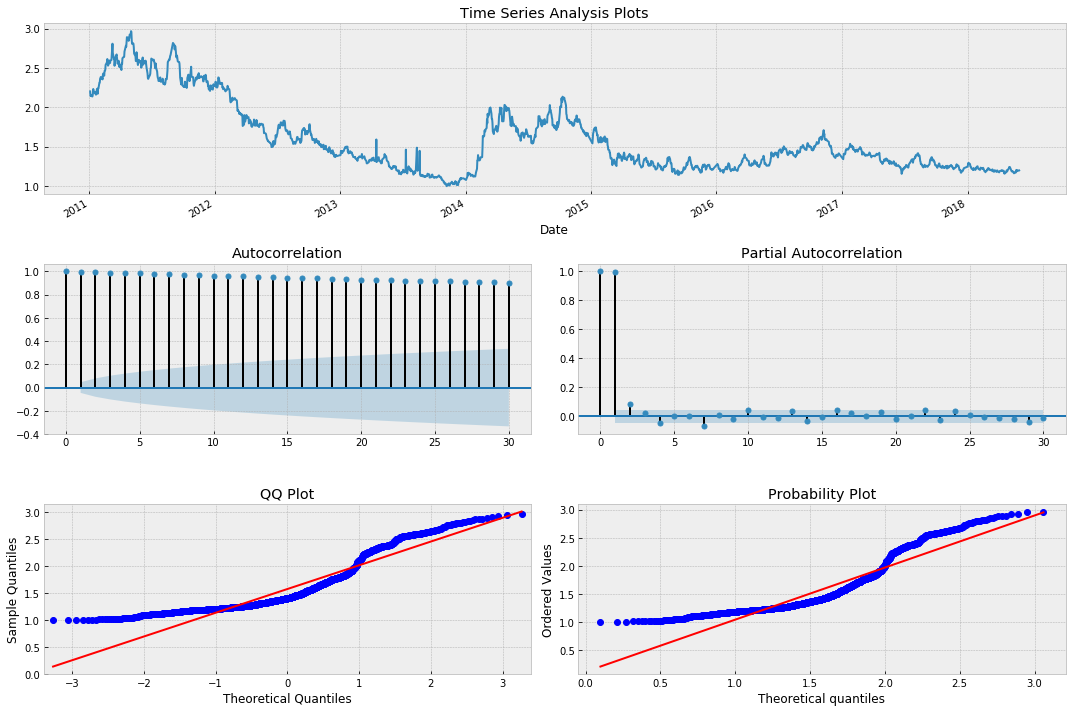

In [8]:
ts = df_adj['Close']

rolling_stats = da.roll_stats(ts=ts, window=30)
da.plotscatter(rolling_stats)
da.tsplot(ts, lags=30)

In [9]:
ts = df_adj['Close']

# Try to confirm stationarity
da.test_unitroot_adf(ts=ts)
da.test_unitroot_phillips_perron(ts=ts)

# Try to confirm unit-root
da.test_stationarity_kpss(ts=ts)

   Augmented Dickey-Fuller Results   
Test Statistic                 -1.723
P-value                         0.419
Lags                               23
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

-----------------------------------------------------

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -1.749
P-value                         0.406
Lags                               25
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

-----------------------------------------------------

    KPSS Stationarity Test Results   
Test Statistic                  3.570
P-value                         0.000
Lags                               2

## <span style='color:MediumBlue'>2.3.</span> Transformations

### <span style='color:Goldenrod'>2.3.1</span> Log-transform

In [10]:
df = df_adj

# Log-transform
df_log = df.applymap(np.log)

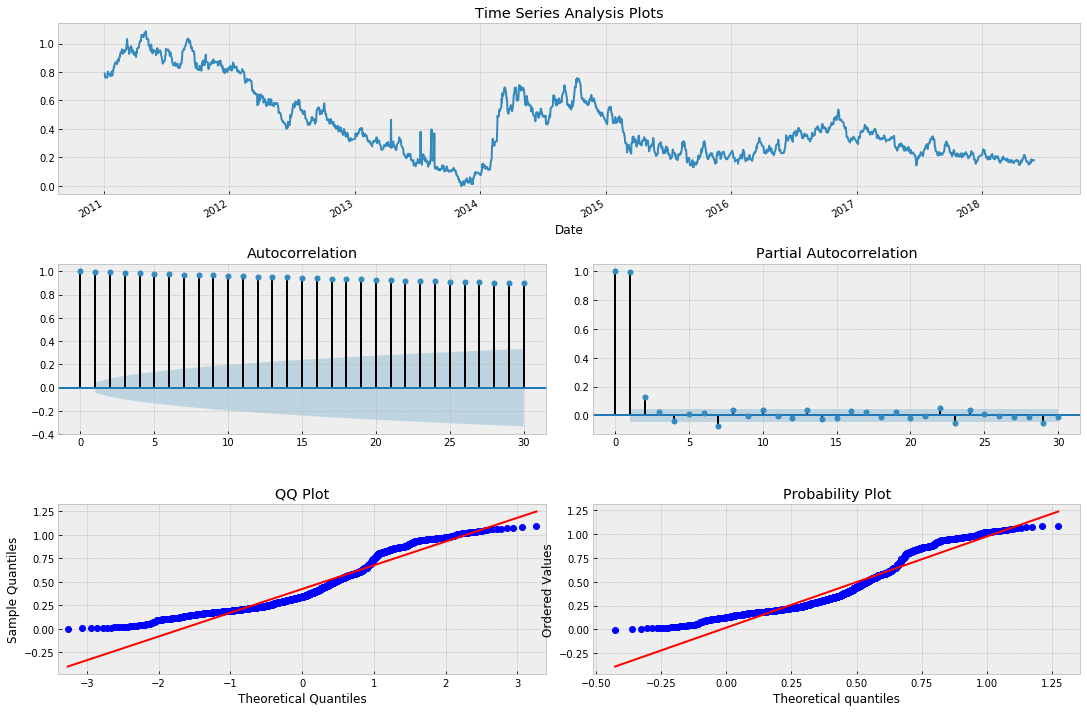

In [11]:
ts = df_log['Close']

rolling_stats = da.roll_stats(ts=ts, window=30)
da.plotscatter(rolling_stats)
da.tsplot(ts, lags=30)

In [12]:
ts = df_log['Close']

# Try to confirm stationarity
da.test_unitroot_adf(ts=ts)
da.test_unitroot_phillips_perron(ts=ts)

# Try to confirm unit-root
da.test_stationarity_kpss(ts=ts)

   Augmented Dickey-Fuller Results   
Test Statistic                 -1.761
P-value                         0.400
Lags                               23
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

-----------------------------------------------------

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -1.791
P-value                         0.385
Lags                               25
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

-----------------------------------------------------

    KPSS Stationarity Test Results   
Test Statistic                  3.426
P-value                         0.000
Lags                               2

### <span style='color:Goldenrod'>2.3.1</span> Differencing

In [13]:
df = df_log

df_log_diff = da.difference_ts(df=df)

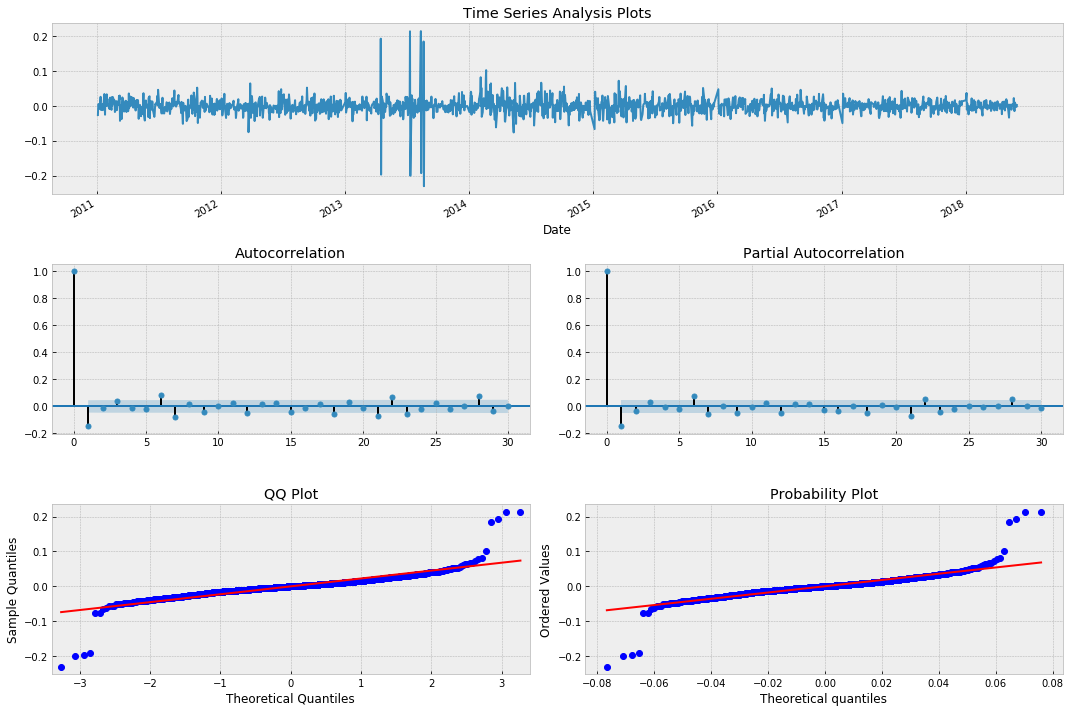

In [14]:
ts = df_log_diff['Close']

rolling_stats = da.roll_stats(ts=ts, window=30)
da.plotscatter(df_log_diff)
da.tsplot(ts, lags=30)

In [15]:
ts = df_log_diff['Close']

# Try to confirm stationarity
da.test_unitroot_adf(ts=ts)
da.test_unitroot_phillips_perron(ts=ts)

# Try to confirm unit-root
da.test_stationarity_kpss(ts=ts)

   Augmented Dickey-Fuller Results   
Test Statistic                -10.159
P-value                         0.000
Lags                               22
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

-----------------------------------------------------

     Phillips-Perron Test (Z-tau)    
Test Statistic                -50.313
P-value                         0.000
Lags                               25
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

-----------------------------------------------------

    KPSS Stationarity Test Results   
Test Statistic                  0.062
P-value                         0.801
Lags                               2

# <span style='color:crimson'>3.</span> Data fitting

In [16]:
def forecast_return_volatility(ts, mu=0, phi=[], theta=[], gmu=0, alpha=[], beta=[]):
    '''1-step ahead prediction for an ARMA-GARCH combination

       Input:
       ts    -- Pandas Series with time series
       mu    -- Mean of ARMA process           (default:  0)
       phi   -- AR coefficients of ARMA model  (default: [])
       theta -- MA coefficients of ARMA model  (default: [])
       gmu   -- Mean of GARCH process          (default:  0)
       alpha -- AR coefficients of GARCH model (default: [])
       beta  -- MA coefficients of GARCH model (default: [])
       
       Default model is white noise (ARMA(0,0) with mean 0). 
       The means, both of ARMA and GARCH, are considered to be 0.
       
       Output:
       pred -- Pandas DataFrame with 1-step ahead forecasted returns and volatility
    '''
    # Cardinalities
    n = len(ts.values) # number of samples
    p = len(phi)       # number of AR coefficients
    q = len(theta)     # number of MA coefficients
    m = len(alpha)     # number of GARCH-AR coefficients
    s = len(beta)      # number of GARCH-MA coefficients
    
    # Series (append zeros in beginning for convenience in loop)
    y = ts.values.reshape(n)
    r = np.zeros(shape=n)                     # array with returns
    a = np.zeros(shape=n)                     # array with shocks
    s2 = np.zeros(shape=n)                    # array with sigmas^2
    e = np.full(shape=n, fill_value=np.nan)   # array with eps = standardized shocks = residuals of GARCH
    
    # Loop over time horizon
    for t in range(n):
        # Predict return in time t
        AR  = np.inner(  phi[0:min(t,p)], np.flip(  y[max(0,t-p):t], axis=-1)).astype(float) # AR term
        MA  = np.inner(theta[0:min(t,q)], np.flip(  a[max(0,t-q):t], axis=-1)).astype(float) # MA term
        r[t] = mu + AR - MA     # add terms to get expected value of ARMA prediction
        a[t] = r[t] - y[t] # residual
        
        if len(alpha)>0 or len(beta)>0:
            # Evaluate volatility process
            gAR = np.inner(alpha[0:min(t,m)], np.flip(a[max(0,t-m):t]**2, axis=-1)).astype(float) # GARCH-AR term
            gMA = np.inner( beta[0:min(t,s)], np.flip(  s2[max(0,t-s):t], axis=-1)).astype(float) # GARCH-MA term
            s2[t] = gmu + gAR + gMA  # add terms to get volatility

            # Evaluate standardized shocks (residuals of GARCH process)
            assert s2[t]>=0.0
            e[t] = a[t]/np.sqrt(s2[t])
    
    # Create DataFrame with results
    matrx = np.concatenate((r.reshape(n,1),a.reshape(n,1),(a**2).reshape(n,1),s2.reshape(n,1),e.reshape(n,1)), axis=1)
    pred = pd.DataFrame(data=matrx, index=ts.index, 
                        columns=['Pred. Return','Shocks','Shocks^2','Volatility','Std Shocks'])
    return pred

In [17]:
def best_model_order(ts, p_rng, q_rng):
    ts = ts.dropna(axis=0,how='any')
    best_aic = np.inf 
    best_order = None
    best_mdl = None
    
    # Some models raise an exception of dividing by NaN or 0
    np.seterr(divide='ignore', invalid='ignore')

    all_aic = np.full(shape=(max(p_rng)+1,max(q_rng)+1), fill_value=np.nan)
    for i in p_rng:
        for j in q_rng:
            if i is 0 and j is 0: continue
            try:
#                 tmp_mdl = sm.tsa.ARIMA(ts, order=(i,0,j)).fit(method='mle', trend='c', maxiter=300)
                tmp_mdl = sm.tsa.SARIMAX(ts, order=(i,0,j), trend='c', maxiter=300).fit(solver='lbfgs')
                tmp_aic = tmp_mdl.aic
                all_aic[i,j] = tmp_aic
                if tmp_aic < best_aic:
                    best_mdl = tmp_mdl
                    best_aic = tmp_aic
                    best_order = (i, 0, j)
            except: continue
    print('aic: {:6.2f} | order: {}'.format(best_aic, best_order))
    if best_order is None:
        best_order = (1,0,0)
        best_mdl = sm.tsa.SARIMAX(ts, order=best_order, trend='c', maxiter=300).fit(solver='lbfgs')
        print('aic: {:6.2f} | order: {}'.format(best_aic, best_order))
    return best_mdl, best_order, best_aic, all_aic

In [18]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='once')

# Input and gets parameters
ts_in = df_log_diff['Close']
mean_ts = ts_in.mean()
std_ts = ts_in.std()

# Standardizes to mean=0/var=1 and adds 1
ts_in = (ts_in - mean_ts)/std_ts + 1

# Define windows to consider
windows = [63, 126, 252]

# Create a DataFrame to store results
df = pd.DataFrame(columns=['{}'.format(w) for w in windows], index=ts_in.index[max(windows):])

# Horizon of prediction between retraining
h = 14

# for k in range(0,len(df.index),h):
mx = max(windows)
for k in range(mx, len(ts_in.index), h):
    print(k)
    ts_test  = ts_in.iloc[k:k+h]
    for w in windows:
        ts_train = ts_in.iloc[k-w:k]

    #     best_order = (2,0,1)
    #     mdl_train = sm.tsa.SARIMAX(endog=ts_train, order=best_order, trend='c', maxiter=100)
    #     fitted_mdl = mdl_train.fit(solver='lbfgs')  

        fitted_mdl, best_order, _, _ = best_model_order(ts_train, range(4), range(4))

        mdl_test = sm.tsa.SARIMAX(endog=ts_test, order=best_order, trend='c')
        mdl_test = mdl_test.filter(fitted_mdl.params)
        
        adj_values = (mdl_test.predict().values - 1)*std_ts + mean_ts
        df.loc[df.index[k-mx:k-mx+h], '{}'.format(w)] = adj_values

df_out = df
# da.plotscatter(df_out)
# df_out

252


/opt/anaconda3/envs/crypto-env/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1042: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/opt/anaconda3/envs/crypto-env/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



aic: 151.26 | order: (0, 0, 2)
aic: 297.80 | order: (1, 0, 3)
aic: 600.02 | order: (0, 0, 1)
266
aic: 139.13 | order: (0, 0, 2)
aic: 300.59 | order: (3, 0, 3)
aic: 602.77 | order: (0, 0, 1)
280
aic: 125.99 | order: (0, 0, 2)
aic: 300.03 | order: (3, 0, 3)
aic: 594.44 | order: (3, 0, 3)
294
aic: 125.81 | order: (0, 0, 1)
aic: 290.47 | order: (0, 0, 2)
aic: 593.65 | order: (0, 0, 1)
308
aic: 142.44 | order: (0, 0, 1)
aic: 292.82 | order: (0, 0, 2)
aic: 589.21 | order: (3, 0, 3)
322
aic: 156.15 | order: (1, 0, 2)
aic: 305.03 | order: (0, 0, 2)
aic: 605.37 | order: (3, 0, 3)
336
aic: 167.37 | order: (0, 0, 3)
aic: 293.22 | order: (0, 0, 2)
aic: 609.46 | order: (3, 0, 3)
350
aic: 167.45 | order: (0, 0, 3)
aic: 293.74 | order: (2, 0, 1)
aic: 603.33 | order: (3, 0, 3)
364
aic: 163.67 | order: (3, 0, 0)
aic: 287.52 | order: (3, 0, 0)
aic: 592.88 | order: (2, 0, 0)
378
aic: 160.85 | order: (1, 0, 0)
aic: 317.66 | order: (0, 0, 1)
aic: 611.31 | order: (3, 0, 3)
392
aic: 159.34 | order: (1, 0, 0)

aic: 283.38 | order: (1, 0, 0)
aic: 575.53 | order: (0, 0, 1)
1442
aic: 128.60 | order: (1, 0, 1)
aic: 279.33 | order: (1, 0, 0)
aic: 561.42 | order: (0, 0, 1)
1456
aic: 140.42 | order: (1, 0, 3)
aic: 289.17 | order: (3, 0, 1)
aic: 561.74 | order: (2, 0, 2)
1470
aic: 130.42 | order: (1, 0, 0)
aic: 282.32 | order: (1, 0, 2)
aic: 561.05 | order: (0, 0, 1)
1484
aic: 130.81 | order: (1, 0, 0)
aic: 266.72 | order: (1, 0, 1)
aic: 544.59 | order: (1, 0, 0)
1498
aic: 139.26 | order: (1, 0, 0)
aic: 269.29 | order: (1, 0, 1)
aic: 544.00 | order: (0, 0, 1)
1512
aic: 141.58 | order: (1, 0, 0)
aic: 260.20 | order: (1, 0, 0)
aic: 544.32 | order: (1, 0, 0)
1526
aic: 130.24 | order: (1, 0, 0)
aic: 261.50 | order: (1, 0, 0)
aic: 536.39 | order: (1, 0, 0)
1540
aic: 117.73 | order: (2, 0, 2)
aic: 247.26 | order: (0, 0, 1)
aic: 529.73 | order: (1, 0, 0)
1554
aic:  98.14 | order: (0, 0, 1)
aic: 241.10 | order: (0, 0, 1)
aic: 522.78 | order: (1, 0, 0)
1568
aic: 104.60 | order: (2, 0, 2)
aic: 246.96 | order:

In [22]:
df_pred = pd.concat([df_log_diff['Close'], df_out], axis=1)
df_pred = df_pred.dropna(how='any', axis=0)
df_pred

da.plotscatter(df_pred)

## <span style='color:MediumBlue'>3.1.</span> ARMA model selection

### <span style='color:Goldenrod'>3.1.1</span> Pre-select with AIC

## <span style='color:MediumBlue'>3.2.</span> Fitting and refinement

### <span style='color:Goldenrod'>3.1.2</span> Confidence/significance refinement

### <span style='color:Goldenrod'>3.1.3</span> Final selection with Validation Set

## <span style='color:MediumBlue'>3.3.</span> Residual Analysis

### <span style='color:Goldenrod'>3.3.1</span> ARCH effects

### <span style='color:Goldenrod'>3.3.2</span> Serial correlation of residuals

## <span style='color:MediumBlue'>3.4.</span> GARCH model selection

## <span style='color:MediumBlue'>3.5.</span> Fitting

## <span style='color:MediumBlue'>3.6.</span> Standardized Residual Analysis

### <span style='color:Goldenrod'>3.6.1</span> Serial correlation of residuals

# <span style='color:crimson'>4.</span> Testing: One-step-ahead Forecasting

## <span style='color:MediumBlue'>3.1.</span> Iterative

## <span style='color:MediumBlue'>3.1.</span> Daily remodeling

O que precisa ter:
- janela de tempo - quantos dias consideraremos para o modelo?
    - isso pode ser feito utilizando todo o dataset com intervalos randomicos
- 'stride' - saltos de quantos dias ate novo modelo?
    - tambem pode ser estimado com todo o dataset e intervalos randomicos
- Funcoes
    - Tirar log
    - Diferenciar
    - Testes estatisticos
    - Encontrar melhor modelo
    - Predizer (1 dia a frente ou varios)